In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt 

First we define the function that we are going to use for our analysis:

The statuaration vapour pressure [Pa] can be approximated using the August-Roche-Magnus equation

$\huge{ e_{sat}(T) = 610.94 e^{\frac{17.625 T}{T+243.04}} }$

In [3]:
def SaturationVapourPressure(T):
    #saturation vapour pressure [Pa] - August-Roche-Magnus equation
    e_sat = 100 * 6.1094 * np.exp(17.625*T/(T+243.04))
    return e_sat #[Pa]

The derivative is than

$ \huge{ \frac{\partial e_{sat}(T)}{\partial T} = \frac{2617010}{T+243.04} e^{\frac{17.625 T}{T+243.04}}   } $

In [4]:
def SaturationVapourPressureDerivative(T):
    #derivative of the saturation vapour pressure [Pa/K] - August-Roche-Magnus equation
    de_sat_dT = 2.61701e6 * np.exp(17.625*T/(T+243.04)) * (T+243.04)**(-2)
    return de_sat_dT #[Pa/K]

We also need to approximate some aerodynamic parameters that control the turbulent exchange between the land surface and the atmosphere. These include the surface roughness (expressed as roughness length [m]) and the displacement height, which marks the height [m] at which the turbulent exchange becomes effective. With these parameters and the assumption of a logarithmic wind profile, we can calculate the aerodynamic exchange coefficient - here expressed as resistance.

In [5]:
def WaterVapourAerodynamicResistance(z,Uz,hc):
    z_w = z #wind speed measurement hight [m]
    k = 0.41 #von Karman constant [-]
    
    d = 2./3. * hc #displacment hight estmated based on vegetation hight [m]
    z_0m = 0.123 * hc #roughness length momentum [m]
    z_0v = 0.1 * z_0m #roughness length surface [m]
    
    r_av = np.log((z_w-d)/z_0m) * np.log((z_w-d)/z_0v) * (k**2 * Uz)**(-1) 
    
    return r_av

In [6]:
def PenmanMonteith(e0, ea, dedT, R_net, G, z, Uz, hc, r_s):
    
    gamma = 0.066 #psychrometric constant [kPa °C -1] (at sea level  101.325 kPa!)
    rho_air = 1.2250 #density of air at seal level ( 101.325 kPa) and 15°C [kg/m³]
    capacity_air = 1.013e-3 #heat capacity of air [MJ kg -1 °C -1]
        
    r_av = WaterVapourAerodynamicResistance(z, Uz, hc)
    
    LET1 = dedT * (R_net - G) + (86400 * rho_air * capacity_air * (e0 - ea)) / r_av
    LET = LET1 / (dedT + gamma * (1. + r_s/r_av) )
    
    return LET

In [7]:
#load meteorological observations
file = 'data/Samoylov_2002-2011_meteorology.tab'
dataset = pd.read_csv(file,delimiter="\t")
dataset['DateTime'] = pd.to_datetime(dataset['Date/Time'])

dataset = dataset.set_index(['DateTime'])
dataset = dataset.loc['2011-1-1':'2011-8-25'] 

df_mean = dataset.groupby(by=pd.Grouper(freq='D')).mean()
df_min = dataset.groupby(by=pd.Grouper(freq='D')).min()
df_max = dataset.groupby(by=pd.Grouper(freq='D')).max()
 
meteorology_mean = df_mean   
meteorology_min = df_min   
meteorology_max = df_max   

#load wind speed measurments
file = 'data/Samoylov_2002-2011_wind_speed.tab'
dataset = pd.read_csv(file,delimiter="\t")
dataset['DateTime'] = pd.to_datetime(dataset['Date/Time'])

dataset = dataset.set_index(['DateTime'])
dataset = dataset.loc['2011-1-1':'2011-8-25'] 

windspeed_mean = dataset.groupby(by=pd.Grouper(freq='D')).mean()

In [8]:
print(meteorology_mean.keys())
print(windspeed_mean.keys())

Index(['Height [m]', 'T2 [°C]', 'RH [%]', 'NET [W/m**2]', 'Precip [mm/h]'], dtype='object')
Index(['Height [m]', 'ff [m/s]'], dtype='object')


<AxesSubplot:xlabel='DateTime'>

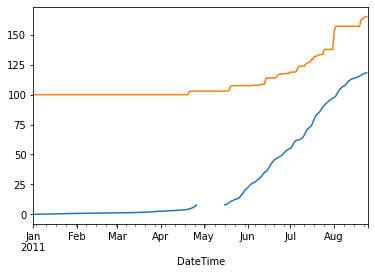

In [10]:
#variables
Uz_av = windspeed_mean['ff [m/s]']
Rnet = np.array([0,200,600])#[W/m²s]

#Note net radiation and groud heat flux must be proved as [MJ m^2 / day] 
dt = 86400
Rnet_av = meteorology_mean['NET [W/m**2]']
Rnet_av = Rnet_av * dt / 1e6

G_av = Rnet_av*0.02 
T_av = meteorology_mean['T2 [°C]'] 
RH_av = meteorology_mean['RH [%]'] / 100.
ea = RH_av * SaturationVapourPressure(T_av)/1000.
dedT = SaturationVapourPressureDerivative(T_av)/1000.
T_min = meteorology_min['T2 [°C]']
T_max = meteorology_max['T2 [°C]']
e0 = 0.5 * (SaturationVapourPressure(T_min) + SaturationVapourPressure(T_max))/1000.

#input parameter for Penman Monteith equation    
z = 3.0 #[m] wind speed mesurmeent hight above ground
hc = 0.10 #[m] crop (vegetation) hight above ground
rs = 250 #[-] surface resitance to evapotranspiration

#apply the Penman Monteith equation 
LET = PenmanMonteith(e0, ea, dedT, Rnet_av, G_av, z, Uz_av, hc, rs) #[MJ/m²day]
#transfrom from [MJ/day] to [mm]
L = 2.45 #[MJ kg -1]
ET = LET/L #[mm/day]

#Note that percipitation was measured as mm/h which must be intergrated over 24h 
P = meteorology_mean['Precip [mm/h]']*24.
S_snow = 100. #[mm]

ET.cumsum().plot()
(P.cumsum() + S_snow).plot()